In [2]:
import cv2
import os
import numpy as np
import tensorflow.keras as keras
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.utils import to_categorical
from keras.applications import ResNet50
from keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from keras import layers
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Add
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from sklearn.metrics import confusion_matrix , accuracy_score

In [3]:
#Model Parameters
batch_size = 8
learning_rate = 0.0001
EPOCHS =8

In [4]:
# Set the directory paths for the benign and malignant images
benign_dir = 'Dataset/Benign Masses'
malignant_dir = 'Dataset/Malignant Masses'

# Target size for resizing
target_size = (224, 224)

# Lists to store the images and labels
images = []
labels = []

# Function to resize and process the images
def process_image(image_path, label):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    resized_image = cv2.resize(image, target_size)
    images.append(resized_image)
    labels.append(label)

# Processing the benign images
for filename in os.listdir(benign_dir):
    image_path = os.path.join(benign_dir, filename)
    process_image(image_path, label='benign')

# Processing the malignant images
for filename in os.listdir(malignant_dir):
    image_path = os.path.join(malignant_dir, filename)
    process_image(image_path, label='malignant')

In [5]:
#Converting lists to numpy arrays
images = np.array(images)/255.0
labels = np.array(labels)

In [6]:
#Encoding labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
#One-hot-encoding our labels
labels = to_categorical(labels)

In [8]:
# Assuming X contains your feature data and y contains your target labels
trainX, testX, trainY, testY = train_test_split(images, labels, test_size=0.2, random_state=42)

In [9]:
#Data augmentation
trainAug = ImageDataGenerator(rotation_range=15, fill_mode = "nearest")

In [10]:
def build_model(backbone, learning_rate=1e-4):
    model = Sequential()
    model.add(backbone)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dropout(0.5))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(2, activation='softmax'))
    
    
    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(learning_rate=learning_rate),
        metrics=['accuracy']
    )
    
    return model

In [11]:
resnet = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(224,224,3)
)


model = build_model(resnet ,learning_rate = 1e-4)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 batch_normalization (BatchN  (None, 2048)             8192      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 2)                 4098      
                                                                 
Total params: 23,600,002
Trainable params: 23,542,786
No

In [12]:
# Compile the model
opt = Adam  (learning_rate=0.0001)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

H = model.fit(
    trainAug.flow(trainX, trainY, batch_size=batch_size),
    steps_per_epoch=trainX.shape[0] / batch_size,
    epochs=EPOCHS,
    )


# Evaluate the model
loss, accuracy = model.evaluate(testX, testY)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

Epoch 1/8
29/29 [==============================] - 80s 2s/step - loss: 0.7257 - accuracy: 0.6638
Epoch 2/8
29/29 [==============================] - 50s 2s/step - loss: 0.5370 - accuracy: 0.7716
Epoch 3/8
29/29 [==============================] - 50s 2s/step - loss: 0.3051 - accuracy: 0.8793
Epoch 4/8
29/29 [==============================] - 50s 2s/step - loss: 0.3200 - accuracy: 0.8879
Epoch 5/8
29/29 [==============================] - 50s 2s/step - loss: 0.3266 - accuracy: 0.8879
Epoch 6/8
29/29 [==============================] - 50s 2s/step - loss: 0.3691 - accuracy: 0.8922
Epoch 7/8
29/29 [==============================] - 53s 2s/step - loss: 0.2501 - accuracy: 0.9310
Epoch 8/8
2/2 [==============================] - 3s 852ms/step - loss: 0.8361 - accuracy: 0.5172
Test Loss: 0.8361
Test Accuracy: 0.5172


In [13]:
#make predictions on the testing set
print("[INFO] network evaluation...")
predIdxs= model.predict(testX,batch_size=batch_size)

[INFO] network evaluation...
8/8 [==============================] - 3s 297ms/step


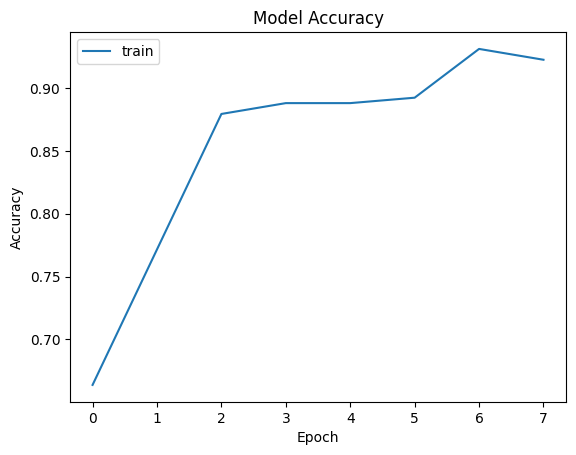

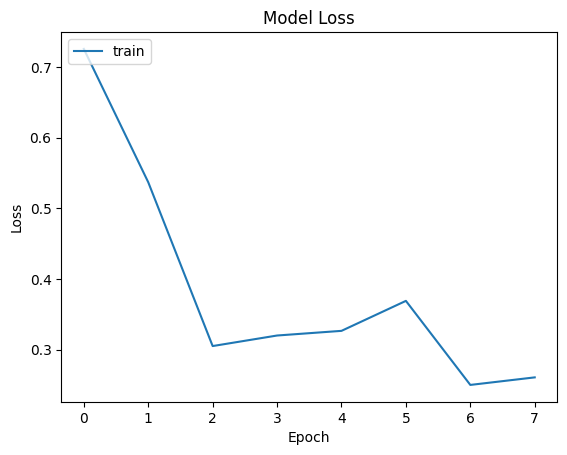

In [14]:
#Summarizing history for accuracy
plt.plot(H.history['accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

#Summarizing history for loss
plt.plot(H.history['loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [15]:
#make predictions on the testing set
print("[INFO] network evaluation...")
predIdxs= model.predict(testX,batch_size=batch_size)

[INFO] network evaluation...
8/8 [==============================] - 2s 282ms/step


In [18]:
#classification report
y_pred = model.predict(testX)>0.5
print(classification_report(testY,y_pred,digits=4,target_names=['B','M']))

2/2 [==============================] - 2s 872ms/step
              precision    recall  f1-score   support

           B     1.0000    0.6071    0.7556        28
           M     0.7317    1.0000    0.8451        30

   micro avg     0.8103    0.8103    0.8103        58
   macro avg     0.8659    0.8036    0.8003        58
weighted avg     0.8612    0.8103    0.8019        58
 samples avg     0.8103    0.8103    0.8103        58



In [19]:
# Convert multi-class labels to discrete binary format
testY_discrete = np.argmax(testY, axis=1)
predIdxs_discrete = np.argmax(predIdxs, axis=1)

# Calculation of the confusion matrix
cm = confusion_matrix(testY_discrete, predIdxs_discrete)

# Calculation of accuracy
accuracy = accuracy_score(testY_discrete, predIdxs_discrete) * 100

# Display the confusion matrix and accuracy
print("Confusion Matrix:")
print(cm)
print("Accuracy: {:.2f}%".format(accuracy))

Confusion Matrix:
[[17 11]
 [ 0 30]]
Accuracy: 81.03%
